In [1]:
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm,lines
from matplotlib.patches import Rectangle,Circle,Ellipse,FancyBboxPatch,FancyArrowPatch
import pandas as pd
from pandas.plotting import scatter_matrix
from PIL import Image
import squarify
from adjustText import adjust_text
from highlight_text.htext import htext, fig_htext
plt.rcParams['pdf.fonttype'] = 42 # Allows chosen font to work when saving images to pdf

import draw_pitch as dp

plt.style.use('football')

%matplotlib inline

Player locations in formations for plotting.

In [2]:
formations = {'3-4-3': [[30,30,30,55,50,50,55,75,85,75],[25,40,55,10,30,50,70,20,40,60]],
              '3-5-2': [[30,30,30,55,50,55,65,65,90,90],[25,40,55,10,40,70,30,50,25,55]],
              '4-2-3-1': [[35,25,25,35,50,50,75,75,75,90],[10,30,50,70,30,50,20,40,60,40]],
              '4-3-3': [[35,25,25,35,45,60,60,80,90,80],[10,30,50,70,40,25,55,15,40,65]]}

In [3]:
datadir = os.path.abspath("data/fbref")
abbr = "/liv"
team = 'Liverpool'

Read match data.

In [4]:
matches = pd.read_csv(datadir + abbr + "/matches.csv")

Set limit for number of 90s played.

In [5]:
nineties = 10

Two functions to rename certain columns in the *Passing* and *Defense* data sets.

In [6]:
def sort_pass(x):
    if x.endswith('.1'):
        x = x[:-2] + ' Short'
    elif x.endswith('.2'):
        x = x[:-2] + ' Medium'
    elif x.endswith('.3'):
        x = x[:-2] + ' Long'
    return x

def sort_def(x):
    if x == 'Tkl.1':
        x = 'Tkl Drib'
    elif x.endswith('.1'):
        x = x[:-2] + ' Press'
    return x

Function for reading and sorting the FbRef data.

In [7]:
def read_fbref_csv(stat,total=False):
    df = pd.read_csv(datadir + abbr + "/{}.csv".format(stat), header=1, index_col="Player")
    df.index = df.index.str.split('\\',expand=True).droplevel(1)
    df.drop(['Nation','Matches'],axis=1, inplace=True)
    df = df[(df['Pos'] != 'GK')&(df['90s'] > nineties)].copy()
    df['pos_colour'] = df['Pos'].replace({'DF':'#004d98','MF':'#edbb00','FW':'#a50044','GK':'xkcd:green',
                                            'MFFW':'#edbb00','FWMF':'#a50044','DFMF':'#edbb00'})
    
    if stat == "passing":
        df.rename(lambda x: sort_pass(x), axis=1, inplace=True)
    elif stat == "defense":
        df.rename(lambda x: sort_def(x), axis=1, inplace=True)
    
    if total == True:
        df = df.loc['Squad Total']
    else:
        df.drop('Squad Total', inplace=True)
    
    return df

Reading in the data and assigning to variables.

In [8]:
stats = ["shooting","passing","pass_type","gs_creation","defense","possession","playing_time"]
sht,pas,pst,gsc,dfn,pos,pti = [read_fbref_csv(i) for i in stats]
sht_total,pas_total,pst_total,gsc_total,dfn_total,pos_total,pti_total = [read_fbref_csv(i,total=True) for i in stats]

Summed *touch*, *tackle* and *press* numbers for heatmaps.

In [9]:
touch_sum = pos_total['Def 3rd']+pos_total['Mid 3rd']+pos_total['Att 3rd']
tackle_sum = dfn_total['Def 3rd']+dfn_total['Mid 3rd']+dfn_total['Att 3rd']
press_sum = dfn_total['Def 3rd Press']+dfn_total['Mid 3rd Press']+dfn_total['Att 3rd Press']

In [10]:
cmap = cm.get_cmap('Reds')

Function for labelling the *num* (default 5) largest data points in a scatter plot on both the x and y axes.

In [11]:
def label_point(x, y, ax, labels=None, num=5, fs=11):
    if labels is None:
        a = pd.concat({'x': x, 'y': y}, axis=1)
        a.sort_values('y', ascending=False, inplace=True)
        b = a.sort_values('x', ascending=False)
        labels = np.unique(np.vstack((a.head(5).index.values,b.head(5).index.values)))
        texts = [ax.text(a.loc[i]['x'], a.loc[i]['y'], str(i), fontsize=fs) for i in labels]
    else:
        labels = labels
        a = pd.concat({'x': x, 'y': y}, axis=1)
        texts = [ax.text(a.loc[i]['x'], a.loc[i]['y'], str(i), fontsize=fs) for i in labels]
    return texts, labels

Function for creating rounded bars on a bar plot. The bars are replaced by FancyPatch instances.

In [12]:
def round_bars(bars, ax, pad=-0.0040, rs=0.3):
    new_patches = []
    for patch in reversed(bars.patches):
        bb = patch.get_bbox()
        color=patch.get_facecolor()
        p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad={},rounding_size={}".format(pad,rs),
                            ec="k", fc=color)
        patch.remove()
        new_patches.append(p_bbox)
    for patch in new_patches:
        ax.add_patch(patch)
    return new_patches

Function to set the upper and lower limits, and their sizes, of points on a scatter plot.

In [13]:
def convert_to_size(x, old_min, old_max, new_min, new_max):
    x = np.array(x)
    r_max = np.sqrt(new_max)
    r_min = np.sqrt(new_min)
    old_range = old_max - old_min
    r_range = r_max - r_min
    r_value = (((x - old_min) * r_range) / old_range) + r_min
    return r_value**2

## Formation

In [14]:
matches['Formation'].value_counts(normalize=True)

4-3-3      0.896552
4-2-3-1    0.103448
Name: Formation, dtype: float64

In [15]:
shape1 = matches['Formation'].value_counts(normalize=True).index[0]
shape2 = matches['Formation'].value_counts(normalize=True).index[1]

## Overview plot

The complete overview plot is shown here. More exploratory plots are shown below.

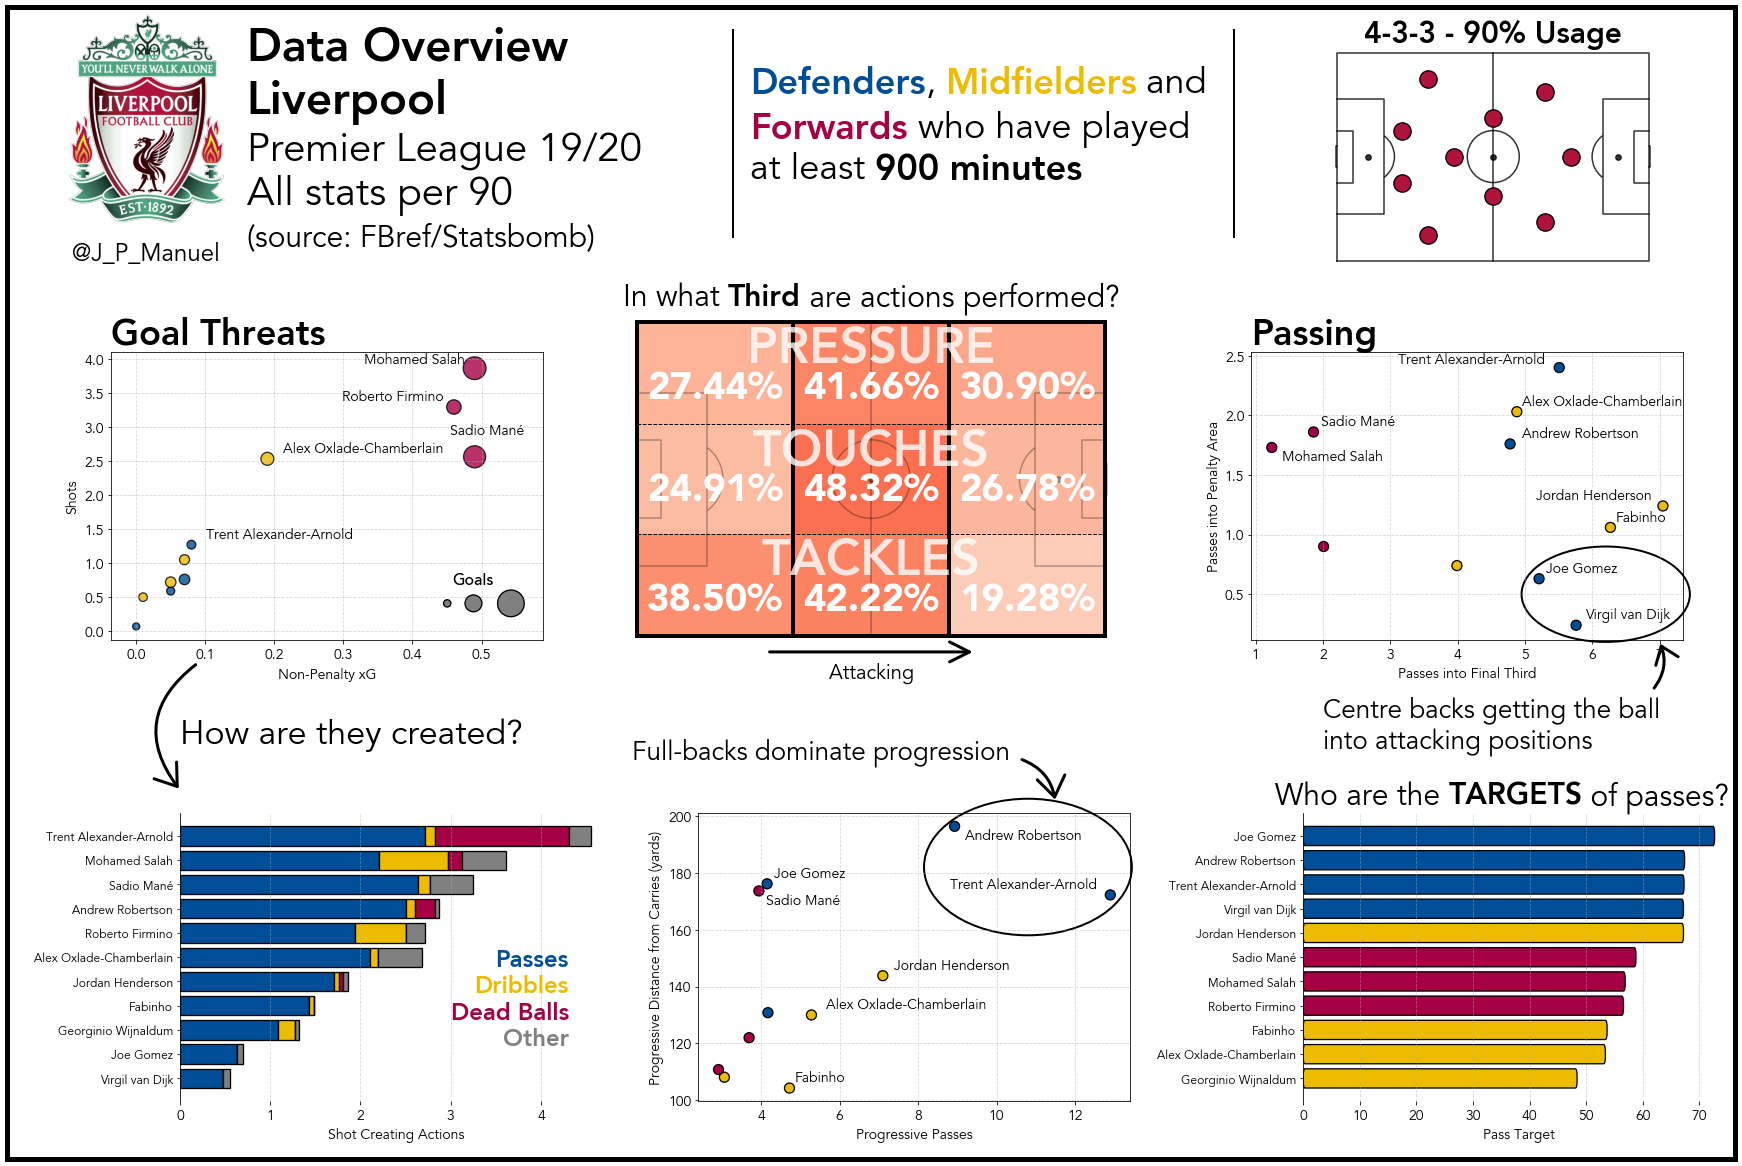

In [16]:
tc = '#af133c'

fig = plt.figure(figsize=(24,16))

badge_dir = "images/badges/prem"
# Add badge
im = Image.open(badge_dir + abbr + ".png")
width, height = im.size
im = im.crop((0.25*width,0,0.7*width,height))
ax_badge = fig.add_axes([-0.02,0.80,0.2,0.2])
ax_badge.imshow(im,interpolation='hanning')
ax_badge.axis('off')
ax_badge.text(1.05,0.92,'Data Overview\n{}'.format(team),transform=ax_badge.transAxes,fontsize=46,fontweight='heavy',
             va='top')
ax_badge.text(1.05,0.33,'Premier League 19/20',fontsize=40,transform=ax_badge.transAxes)
ax_badge.text(1.05,0.14,'All stats per 90',fontsize=40,transform=ax_badge.transAxes)
ax_badge.text(1.05,-0.04,'(source: FBref/Statsbomb)',fontsize=30,transform=ax_badge.transAxes)
ax_badge.text(0.5,-0.1,'@J_P_Manuel',fontsize=24,transform=ax_badge.transAxes,ha='center')
line1= lines.Line2D([0.42,0.42],[0.80,0.98],transform=ax_badge.figure.transFigure,lw=2.,c='k',clip_on=False)
ax_badge.add_line(line1)

### Info ###
ax_info = fig.add_axes([0.42,0.83,0.1,0.1])
htext(s='<Defenders>, <Midfielders> and\n<Forwards> who have played\nat least <{} minutes>'.format(nineties*90),
      x=0.1,y=0.1,color='k',highlight_colors=['#004d98','#edbb00','#a50044','k'],fontsize=36,
      string_weight = 'regular',highlight_weights=['bold'])
ax_info.axis('off')
line2= lines.Line2D([0.71,0.71],[0.80,0.98],transform=ax_info.figure.transFigure,lw=2.,c='k',clip_on=False)
ax_info.add_line(line2)

### Formation ###
ax_form = fig.add_axes([0.76,0.77,0.2,0.2])
_, ax_form = dp.draw_pitch('w','k','h','f',figax=(fig,ax_form),alpha=0.8)
ax_form.scatter(formations[shape1][0],formations[shape1][1],s=300,c=tc,zorder=10)
ax_form.text(0.5,1,'{} - {:.0f}% Usage'.format(shape1,matches['Formation'].value_counts(normalize=True)[0]*100),
             fontsize=30,fontweight='heavy',ha='center',transform=ax_form.transAxes)
ax_form.set_aspect(1)

### Shooting ###
ax_shot = fig.add_axes([0.06,0.45,0.25,0.25])
sc = ax_shot.scatter(sht['npxG'], sht['Sh/90'], c=sht['pos_colour'], 
                     s=convert_to_size(sht['Gls'].values, 0., 1., 50, 1000),alpha=0.8)
ymax = max(ax_shot.get_ylim())
xmax = max(ax_shot.get_xlim())
ax_shot.scatter([0.83*xmax,0.9*xmax,xmax],[0.1*ymax,0.1*ymax,0.1*ymax],c='grey',
                s=convert_to_size([0.01,0.4,0.8], 0., 1., 50, 1000),zorder=10)
ax_shot.set_xlabel("Non-Penalty xG")
ax_shot.set_ylabel("Shots")
label_list,_ = label_point(sht['npxG'],sht['Sh/90'],ax_shot,fs=14)
adjust_text(label_list,expand_points=(1.2,1.3),ax=ax_shot)
ax_shot.grid(alpha=0.5,linestyle='--')
ax_shot.text(0.9*xmax,0.18*ymax,'Goals',ha='center',va='center',fontsize=16,fontweight='medium')
ax_shot.text(0.,1,'Goal Threats',ha='left',va='bottom',fontsize=36,transform=ax_shot.transAxes,
            fontweight='heavy')

arrow = FancyArrowPatch((0.11,0.43),(0.10,0.32),transform=ax_shot.figure.transFigure,connectionstyle="arc3,rad=.5",
                        arrowstyle="->,head_width=14,head_length=20",lw=3,clip_on=False,zorder=10)
ax_shot.add_patch(arrow)
ax_shot.text(0.1,0.36,"How are they created?",transform=ax_shot.figure.transFigure,fontsize=34)

### SCA ###
ax_sca = fig.add_axes([0.1,0.05,0.25,0.25])
df = gsc.sort_values('SCA',ascending=False)
ax_sca.barh(np.arange(len(df))[::-1], df['PassLive'])
ax_sca.barh(np.arange(len(df))[::-1], df['Drib'], left=df['PassLive'])
ax_sca.barh(np.arange(len(df))[::-1], df['PassDead'], left=df['PassLive']+df['Drib'])
ax_sca.barh(np.arange(len(df))[::-1], df['SCA']-df['PassLive']-df['Drib']-df['PassDead'], 
            left=df['PassLive']+df['Drib']+df['PassDead'], color='grey')
ax_sca.set_yticks(np.arange(len(df))[::-1])
ax_sca.set_yticklabels(df.index)
ax_sca.set_xlabel("Shot Creating Actions")

ax_sca.tick_params(axis="y", labelsize=12)

ymax = max(ax_sca.get_ylim())
xmax = max(ax_sca.get_xlim())
htext(s="<Passes>",x=0.9*xmax,y=0.4*ymax,fontsize=24,color='k',highlight_colors=['#004d98'],
      highlight_weights=['bold'],ha='right')
htext(s="<Dribbles>",x=0.9*xmax,y=0.3*ymax,fontsize=24,color='k',highlight_colors=['#edbb00'],
      highlight_weights=['bold'],ha='right')
htext(s="<Dead Balls>",x=0.9*xmax,y=0.2*ymax,fontsize=24,color='k',highlight_colors=['#a50044'],
      highlight_weights=['bold'],ha='right')
htext(s="<Other>",x=0.9*xmax,y=0.1*ymax,fontsize=24,color='k',highlight_colors=['grey'],
      highlight_weights=['bold'],ha='right')
ax_sca.grid(alpha=0.5, axis='x', linestyle='--')
ax_sca.spines['top'].set_visible(False)
ax_sca.spines['right'].set_visible(False)
ax_sca.spines['bottom'].set_visible(False)

### Actions ###
ax_actions = fig.add_axes([0.35,0.44,0.3,0.3])
_, ax_actions = dp.draw_pitch('w','k','h','f',figax=(fig,ax_actions),alpha=0.3)
ax_actions.plot([0,0],[0,80],c='k',lw=4)
ax_actions.plot([40,40],[0,80],c='k',lw=4)
ax_actions.plot([80,80],[0,80],c='k',lw=4)
ax_actions.plot([120,120],[0,80],c='k',lw=4)
ax_actions.plot([0,120],[0,0],c='k',lw=4)
ax_actions.plot([0,120],[80,80],c='k',lw=4)

def_3rd_press = Rectangle((0,54),40,26,color=cmap(dfn_total['Def 3rd Press']/press_sum))
mid_3rd_press = Rectangle((40,54),40,26,color=cmap(dfn_total['Mid 3rd Press']/press_sum))
att_3rd_press = Rectangle((80,54),40,26,color=cmap(dfn_total['Att 3rd Press']/press_sum))
ax_actions.add_patch(def_3rd_press)
ax_actions.add_patch(mid_3rd_press)
ax_actions.add_patch(att_3rd_press)
ax_actions.text(20,63,'{:.2f}%'.format((dfn_total['Def 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(60,63,'{:.2f}%'.format((dfn_total['Mid 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(100,63,'{:.2f}%'.format((dfn_total['Att 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(60,73,'PRESSURE',c='w',fontsize=50,weight='heavy',ha='center',va='center',alpha=0.8)
ax_actions.plot([0,120],[54,54],c='k',ls='--',lw=1)

def_3rd_pos = Rectangle((0,26),40,28,color=cmap(pos_total['Def 3rd']/touch_sum))
mid_3rd_pos = Rectangle((40,26),40,28,color=cmap(pos_total['Mid 3rd']/touch_sum))
att_3rd_pos = Rectangle((80,26),40,28,color=cmap(pos_total['Att 3rd']/touch_sum))
ax_actions.add_patch(def_3rd_pos)
ax_actions.add_patch(mid_3rd_pos)
ax_actions.add_patch(att_3rd_pos)
ax_actions.text(20,37,'{:.2f}%'.format((pos_total['Def 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(60,37,'{:.2f}%'.format((pos_total['Mid 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(100,37,'{:.2f}%'.format((pos_total['Att 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(60,47,'TOUCHES',c='w',fontsize=50,weight='heavy',ha='center',va='center',alpha=0.8)
ax_actions.plot([0,120],[26,26],c='k',ls='--',lw=1)

def_3rd_dfn = Rectangle((0,0),40,26,color=cmap(dfn_total['Def 3rd']/tackle_sum))
mid_3rd_dfn = Rectangle((40,0),40,26,color=cmap(dfn_total['Mid 3rd']/tackle_sum))
att_3rd_dfn = Rectangle((80,0),40,26,color=cmap(dfn_total['Att 3rd']/tackle_sum))
ax_actions.add_patch(def_3rd_dfn)
ax_actions.add_patch(mid_3rd_dfn)
ax_actions.add_patch(att_3rd_dfn)
ax_actions.text(20,9,'{:.2f}%'.format((dfn_total['Def 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(60,9,'{:.2f}%'.format((dfn_total['Mid 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(100,9,'{:.2f}%'.format((dfn_total['Att 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax_actions.text(60,19,'TACKLES',c='w',fontsize=50,weight='heavy',ha='center',va='center',alpha=0.8)

htext(s="In what <Third> are actions performed?",x=60,y=82,fontsize=30,highlight_colors=['k'],
      highlight_weights=['bold'],ha='center',va='bottom')
arrow2 = FancyArrowPatch((0.3,-0.),(0.7,-0.),transform=ax_actions.transAxes,connectionstyle="arc3,rad=0",
                        arrowstyle="->,head_width=10,head_length=20",lw=3,clip_on=False,zorder=10)
ax_actions.add_patch(arrow2)
ax_actions.text(0.5,-0.03,"Attacking",transform=ax_actions.transAxes,fontsize=20,ha='center',va='top')

### Progression ###
ax_prog = fig.add_axes([0.40,0.05,0.25,0.25])
ax_prog.scatter(pas['Prog'], pos['PrgDist'], c=pos['pos_colour'])
ax_prog.set_xlabel("Progressive Passes")
ax_prog.set_ylabel("Progressive Distance from Carries (yards)")
label_list,_ = label_point(pas['Prog'],pos['PrgDist'],ax_prog,fs=14)
adjust_text(label_list,expand_points=(1.2,1.3))
ax_prog.grid(alpha=0.5, linestyle='--')
ellipse1 = Ellipse((10.8,182),5.3,48,color='k',fill=False,lw=2,clip_on=False)
ax_prog.add_patch(ellipse1)
arrow3 = FancyArrowPatch((10.6,220),(11.5,205),connectionstyle="arc3,rad=-0.3",
                         arrowstyle="->,head_width=14,head_length=20",lw=3,clip_on=False,zorder=10)
ax_prog.add_patch(arrow3)
ax_prog.text(0.7,220,"Full-backs dominate progression",
             fontsize=26)

### Passing ###
df = pas
ax_pas = fig.add_axes([0.72,0.45,0.25,0.25])
ax_pas.scatter(df['1/3'], df['PPA'], c=pas['pos_colour'])
ax_pas.set_xlabel("Passes into Final Third")
ax_pas.set_ylabel("Passes into Penalty Area")
label_list,_ = label_point(df['1/3'],df['PPA'],ax_pas,fs=14)
adjust_text(label_list,expand_points=(1.2,1.3))
ax_pas.grid(alpha=0.5, linestyle='--')
ax_pas.text(0.,1,'Passing',ha='left',va='bottom',fontsize=36,transform=ax_pas.transAxes,fontweight='heavy')
ellipse2 = Ellipse((6.2,0.5),2.5,0.8,color='k',fill=False,lw=2,clip_on=False)
ax_pas.add_patch(ellipse2)
arrow4 = FancyArrowPatch((6.9,-0.3),(7,0.1),connectionstyle="arc3,rad=0.3",
                         arrowstyle="->,head_width=12,head_length=16",lw=3,clip_on=False,zorder=10)
ax_pas.add_patch(arrow4)
ax_pas.text(2,-0.8,"Centre backs getting the ball\ninto attacking positions",fontsize=26)

### Pass Target ###
df = pos.sort_values('Targ',ascending=False)
ax_targ = fig.add_axes([0.75,0.05,0.25,0.25])
bars = ax_targ.barh(np.arange(len(df))[::-1], df['Targ'], color=df['pos_colour'])
round_bars(bars,ax_targ)
ax_targ.set_yticks(np.arange(len(df))[::-1])
ax_targ.set_yticklabels(df.index)
ax_targ.set_xlabel("Pass Target")
ax_targ.tick_params(axis="y", labelsize=12)
ymax = max(ax_targ.get_ylim())
htext(s = 'Who are the <TARGETS> of passes?',x=-5, y=ymax,color = 'k', 
      highlight_colors = ['k'],fontsize=30,string_weight = 'regular',
      highlight_weights=['bold'])
ax_targ.grid(alpha=0.5, axis='x', linestyle='--')
ax_targ.spines['top'].set_visible(False)
ax_targ.spines['right'].set_visible(False)
ax_targ.spines['bottom'].set_visible(False)

# Figure limits
ax_bound = fig.add_axes([0.,0.,0.,0.])
rect = plt.Rectangle((0., 0.), 1., 1., clip_on=False, facecolor='none', transform=ax_bound.figure.transFigure,
                    ec='k',lw=5)
ax_bound.add_artist(rect)
ax_bound.axis('off')

#plt.savefig('example_plots/data_overview_liverpool.png',dpi=300,pad_inches=0)
plt.show()

## Playing Time

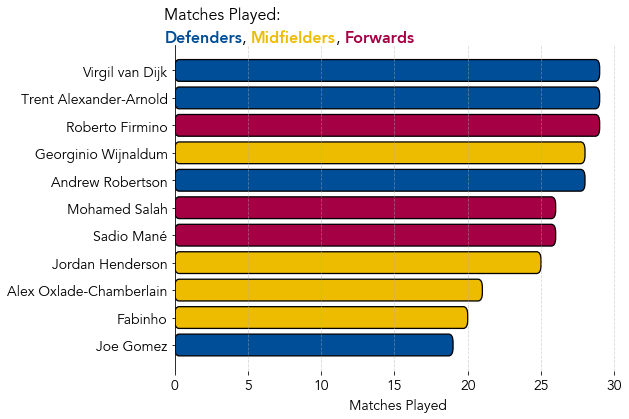

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
bars=ax.barh(np.arange(len(pti))[::-1], pti.sort_values('MP',ascending=False)['MP'], 
        color=pti.sort_values('MP',ascending=False)['pos_colour'])

round_bars(bars,ax)

ax.set_yticks(np.arange(len(pti))[::-1])
ax.set_yticklabels(pti.sort_values('MP',ascending=False).index)
ax.set_xlabel("Matches Played")

ymax = ax.get_ylim()[1]
htext(s = 'Matches Played:\n<Defenders>, <Midfielders>, <Forwards>',x = -0.7, y = ymax,color = 'k', 
      highlight_colors = ['#004d98','#edbb00','#a50044'],fontsize=16,string_weight = 'regular',
      highlight_weights=['bold'])

ax.grid(alpha=0.5, axis='x', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

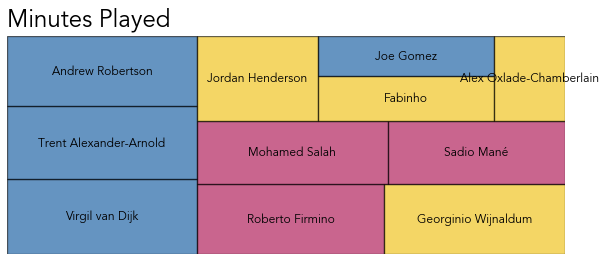

In [18]:
ptiMins = pti.sort_values('Min',ascending=False)

fig,ax = plt.subplots(figsize=(10,4))
squarify.plot(sizes=ptiMins['Min'],color=ptiMins['pos_colour'],label=ptiMins.index,alpha=0.6,
             text_kwargs={'fontsize': 12})
ax.text(0,1.05,'Minutes Played',transform=ax.transAxes,fontsize=24)
ax.axis('off')
plt.show()

## Shooting

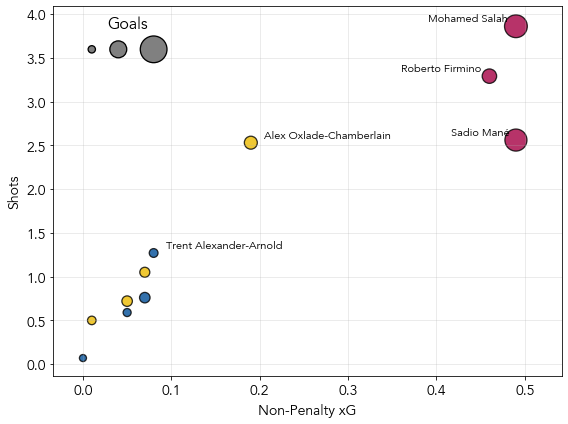

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(sht['npxG'], sht['Sh/90'], c=sht['pos_colour'], 
                s=convert_to_size(sht['Gls'].values, 0., 1., 50, 1000),alpha=0.8)
ymax = max(ax.get_ylim())
ax.scatter([0.01,0.04,0.08],[ymax-(0.12*ymax),ymax-(0.12*ymax),ymax-(0.12*ymax)],c='grey',s=convert_to_size([0.01,0.4,0.8], 0., 1., 50, 1000),zorder=10)
ax.set_xlabel("Non-Penalty xG")
ax.set_ylabel("Shots")
label_list,_ = label_point(sht['npxG'],sht['Sh/90'],ax,fs=11)
adjust_text(label_list,expand_points=(1.2,1.3))
ax.grid(alpha=0.3)

ax.text(0.05,ymax-(ymax*0.05),'Goals',ha='center',va='center',fontsize=16)

plt.tight_layout()
plt.show()

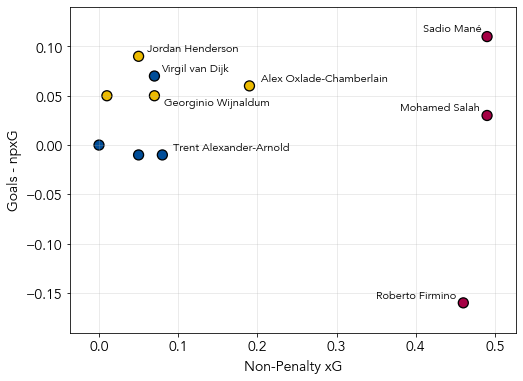

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(sht['npxG'], sht['np:G-xG'], c=sht['pos_colour'])
ax.set_xlabel("Non-Penalty xG")
ax.set_ylabel("Goals - npxG")
label_list,_ = label_point(sht['npxG'],sht['np:G-xG'],ax)
adjust_text(label_list,expand_points=(1.2,1.3))
ax.grid(alpha=0.3)
plt.show()

## Shot and Goal creating actions

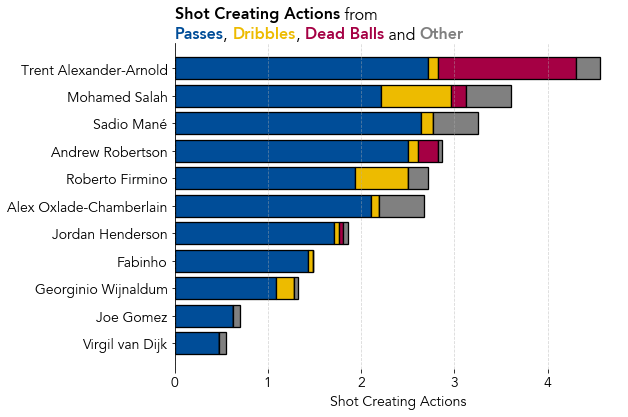

In [21]:
df = gsc.sort_values('SCA',ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(np.arange(len(df))[::-1], df['PassLive'])
ax.barh(np.arange(len(df))[::-1], df['Drib'], left=df['PassLive'])
ax.barh(np.arange(len(df))[::-1], df['PassDead'], left=df['PassLive']+df['Drib'])
ax.barh(np.arange(len(df))[::-1], df['SCA']-df['PassLive']-df['Drib']-df['PassDead'], left=df['PassLive']+df['Drib']+df['PassDead'], color='grey')

ax.set_yticks(np.arange(len(df))[::-1])
ax.set_yticklabels(df.index)
ax.set_xlabel("Shot Creating Actions")

ymax = max(ax.get_ylim())
htext(s = '<Shot Creating Actions> from\n<Passes>, <Dribbles>, <Dead Balls> and <Other>',x=0.0,y=ymax,
      color = 'k', highlight_colors = ['k','#004d98','#edbb00','#a50044','grey'],fontsize=16,
      string_weight = 'regular', highlight_weights=['bold'])

ax.grid(alpha=0.5, axis='x', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

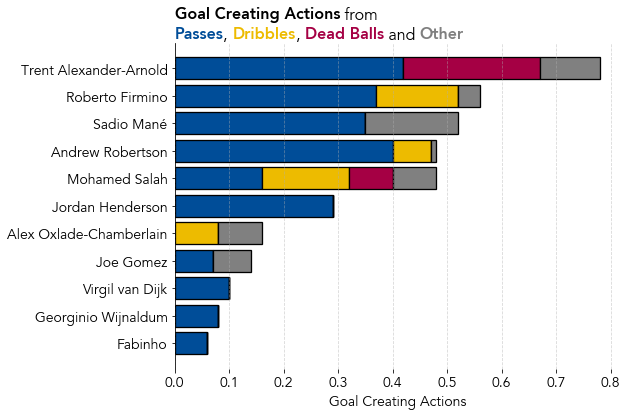

In [22]:
df = gsc.sort_values('GCA',ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(np.arange(len(df))[::-1], df['PassLive.1'])
ax.barh(np.arange(len(df))[::-1], df['Drib.1'], left=df['PassLive.1'])
ax.barh(np.arange(len(df))[::-1], df['PassDead.1'], left=df['PassLive.1']+df['Drib.1'])
ax.barh(np.arange(len(df))[::-1], df['GCA']-df['PassLive.1']-df['Drib.1']-df['PassDead.1'], left=df['PassLive.1']+df['Drib.1']+df['PassDead.1'], color='grey')

ax.set_yticks(np.arange(len(df))[::-1])
ax.set_yticklabels(df.index)
ax.set_xlabel("Goal Creating Actions")

ymax = max(ax.get_ylim())
htext(s = '<Goal Creating Actions> from\n<Passes>, <Dribbles>, <Dead Balls> and <Other>',x=0.0,y=ymax,
      color = 'k', highlight_colors = ['k','#004d98','#edbb00','#a50044','grey'],fontsize=16,
      string_weight = 'regular', highlight_weights=['bold'])

ax.grid(alpha=0.5, axis='x', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

## Passing

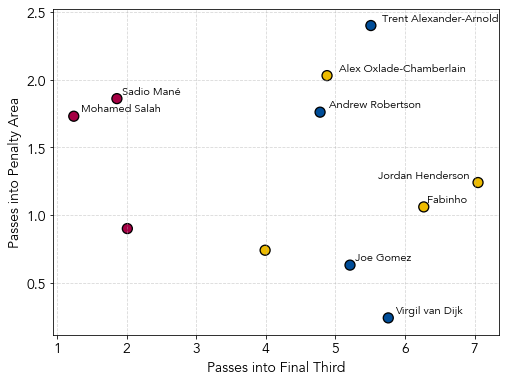

In [23]:
df = pas

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df['1/3'], df['PPA'], c=pas['pos_colour'])
ax.set_xlabel("Passes into Final Third")
ax.set_ylabel("Passes into Penalty Area")
label_list,_ = label_point(df['1/3'],df['PPA'],ax)
adjust_text(label_list,expand_points=(1.2,1.3))
ax.grid(alpha=0.5, linestyle='--')
plt.show()

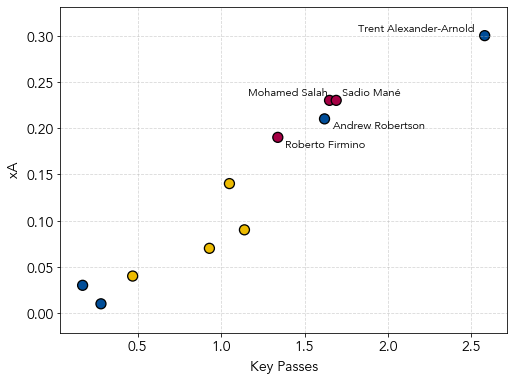

In [24]:
df = pas

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df['KP'], df['xA'], c=pas['pos_colour'])
ax.set_xlabel("Key Passes")
ax.set_ylabel("xA")
label_list,_ = label_point(df['KP'],df['xA'],ax)
adjust_text(label_list,expand_points=(1.2,1.3))
ax.grid(alpha=0.5, linestyle='--')
plt.show()

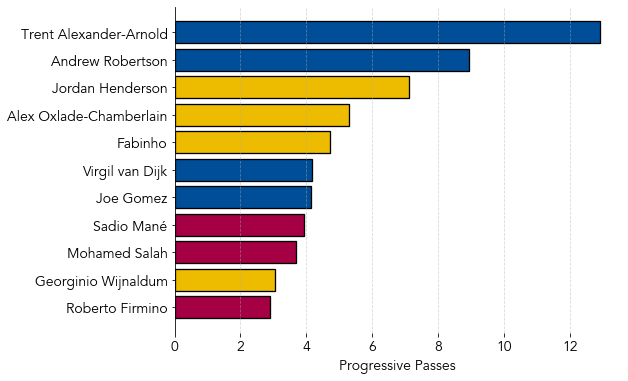

In [25]:
df = pas.sort_values('Prog',ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(np.arange(len(df))[::-1], df['Prog'], color=df['pos_colour'])
ax.set_yticks(np.arange(len(df))[::-1])
ax.set_yticklabels(df.index)
ax.set_xlabel("Progressive Passes")

ax.grid(alpha=0.5, axis='x', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

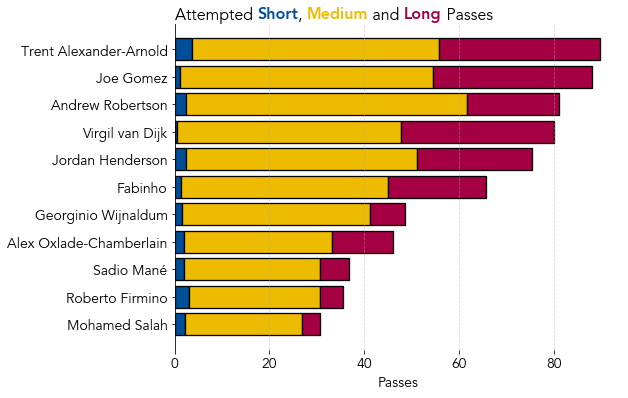

In [26]:
df = pas.sort_values('Att',ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(np.arange(len(df))[::-1], df['Att Short'])
ax.barh(np.arange(len(df))[::-1], df['Att Medium'], left=df['Att Short'])
ax.barh(np.arange(len(df))[::-1], df['Att Long'], left=df['Att Short']+df['Att Medium'])
ax.set_yticks(np.arange(len(df))[::-1])
ax.set_yticklabels(df.index)
ax.set_xlabel("Passes")

ymax = max(ax.get_ylim())
htext(s = 'Attempted <Short>, <Medium> and <Long> Passes',x=0.0, y=ymax,color = 'k', 
      highlight_colors = ['#004d98','#edbb00','#a50044'],fontsize=16,string_weight = 'regular',
      highlight_weights=['bold'])

ax.grid(alpha=0.5, axis='x', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

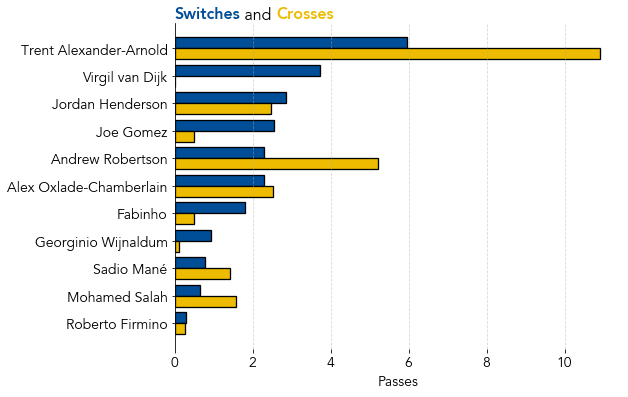

In [27]:
df = pst.sort_values("Sw", ascending=False)

height = 0.4
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(np.arange(len(df))[::-1] + height/2, df['Sw'], height=height)
ax.barh(np.arange(len(df))[::-1] - height/2, df['Crs'], height=height)
#ax.barh(np.arange(len(df))[::-1], df['Att Medium'], left=df['Att Short'])
#ax.barh(np.arange(len(df))[::-1], df['Att Long'], left=df['Att Short']+df['Att Medium'])
ax.set_yticks(np.arange(len(df))[::-1])
ax.set_yticklabels(df.index)
ax.set_xlabel("Passes")

ymax = max(ax.get_ylim())
htext(s = '<Switches> and <Crosses>',x=0.0, y=ymax,color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=16,string_weight = 'regular',
      highlight_weights=['heavy'])

ax.grid(alpha=0.5, axis='x', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

## Possession

In [28]:
fig, ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
def_3rd = Rectangle((0,0),40,80,color=cmap(pos_total['Def 3rd']/touch_sum))
mid_3rd = Rectangle((40,0),40,80,color=cmap(pos_total['Mid 3rd']/touch_sum))
att_3rd = Rectangle((80,0),40,80,color=cmap(pos_total['Att 3rd']/touch_sum))
ax.add_patch(def_3rd)
ax.add_patch(mid_3rd)
ax.add_patch(att_3rd)

ax.plot([0,0],[0,80],c='k',lw=4)
ax.plot([40,40],[0,80],c='k',lw=4)
ax.plot([80,80],[0,80],c='k',lw=4)
ax.plot([120,120],[0,80],c='k',lw=4)
ax.plot([0,120],[0,0],c='k',lw=4)
ax.plot([0,120],[80,80],c='k',lw=4)

ax.text(20,50,'{:.2f}%'.format((pos_total['Def 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,50,'{:.2f}%'.format((pos_total['Mid 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(100,50,'{:.2f}%'.format((pos_total['Att 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')

ax.text(60,80,'Where do {} take their touches?'.format(team),ha='center',va='bottom',fontsize=26)
plt.close()

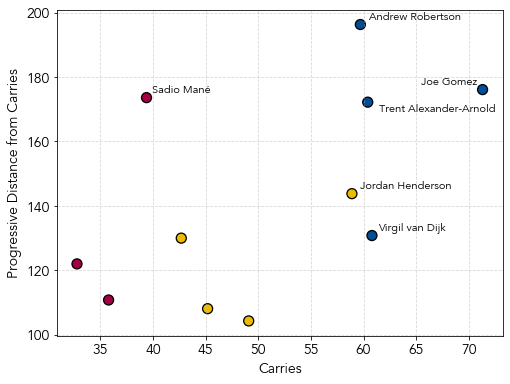

In [29]:
df = pos

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df['Carries'], df['PrgDist'], c=pos['pos_colour'])
ax.set_xlabel("Carries")
ax.set_ylabel("Progressive Distance from Carries")
label_list,_ = label_point(df['Carries'],df['PrgDist'],ax)
adjust_text(label_list,expand_points=(1.2,1.3))
ax.grid(alpha=0.5, linestyle='--')
plt.show()

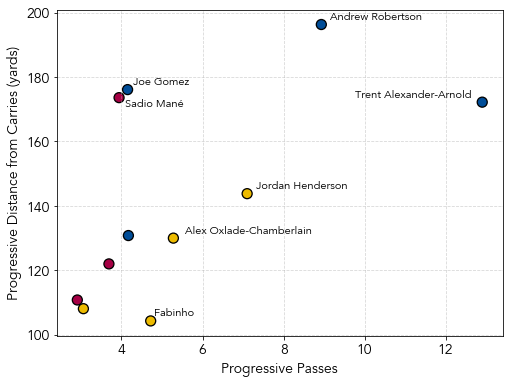

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pas['Prog'], pos['PrgDist'], c=pos['pos_colour'])
ax.set_xlabel("Progressive Passes")
ax.set_ylabel("Progressive Distance from Carries (yards)")
label_list,_ = label_point(pas['Prog'],pos['PrgDist'],ax)
adjust_text(label_list,expand_points=(1.2,1.3))
ax.grid(alpha=0.5, linestyle='--')
plt.show()

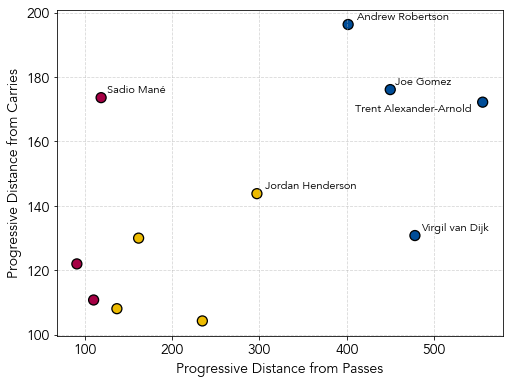

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(pas['PrgDist'], pos['PrgDist'], c=pos['pos_colour'])
ax.set_xlabel("Progressive Distance from Passes")
ax.set_ylabel("Progressive Distance from Carries")
label_list,_ = label_point(pas['PrgDist'],pos['PrgDist'],ax)
adjust_text(label_list,expand_points=(1.2,1.3))
ax.grid(alpha=0.5, linestyle='--')
plt.show()

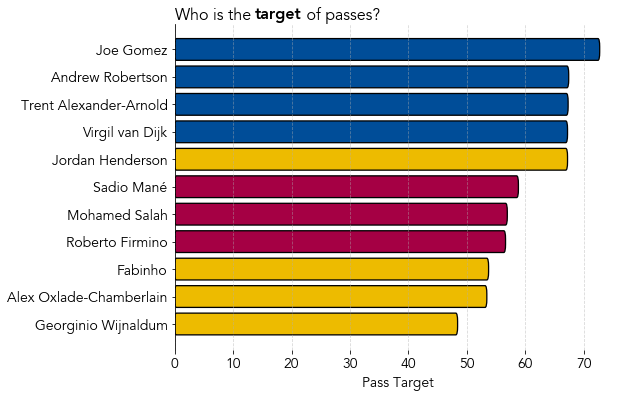

In [32]:
df = pos.sort_values('Targ',ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
bars = ax.barh(np.arange(len(df))[::-1], df['Targ'], color=df['pos_colour'])
round_bars(bars,ax)
ax.set_yticks(np.arange(len(df))[::-1])
ax.set_yticklabels(df.index)
ax.set_xlabel("Pass Target")

ymax = max(ax.get_ylim())
htext(s = 'Who is the <target> of passes?',x=0.0, y=ymax,color = 'k', 
      highlight_colors = ['k'],fontsize=16,string_weight = 'regular',
      highlight_weights=['bold'])

ax.grid(alpha=0.5, axis='x', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

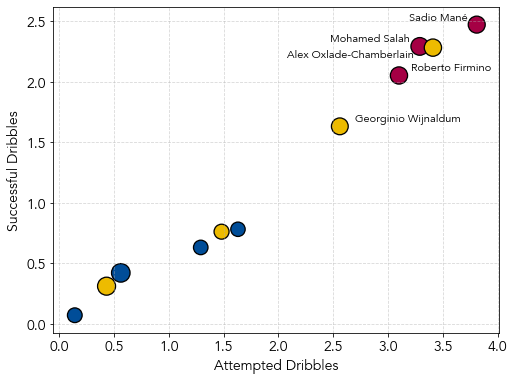

In [33]:
df = pos

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df['Att'], df['Succ'], c=pos['pos_colour'], s=convert_to_size(np.nan_to_num(pos["Succ%"].values),0,100,50,500))
ax.set_xlabel("Attempted Dribbles")
ax.set_ylabel("Successful Dribbles")
label_list,_ = label_point(df['Att'],df['Succ'],ax)
adjust_text(label_list,expand_points=(1.3,1.3))
ax.grid(alpha=0.5, linestyle='--')
plt.show()

## Defense

In [34]:
fig, ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
def_3rd = Rectangle((0,0),40,80,color=cmap(dfn_total['Def 3rd']/tackle_sum))
mid_3rd = Rectangle((40,0),40,80,color=cmap(dfn_total['Mid 3rd']/tackle_sum))
att_3rd = Rectangle((80,0),40,80,color=cmap(dfn_total['Att 3rd']/tackle_sum))
ax.add_patch(def_3rd)
ax.add_patch(mid_3rd)
ax.add_patch(att_3rd)

ax.plot([0,0],[0,80],c='k',lw=4)
ax.plot([40,40],[0,80],c='k',lw=4)
ax.plot([80,80],[0,80],c='k',lw=4)
ax.plot([120,120],[0,80],c='k',lw=4)
ax.plot([0,120],[0,0],c='k',lw=4)
ax.plot([0,120],[80,80],c='k',lw=4)

ax.text(20,50,'{:.2f}%'.format((dfn_total['Def 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,50,'{:.2f}%'.format((dfn_total['Mid 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(100,50,'{:.2f}%'.format((dfn_total['Att 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')

ax.text(60,80,'Where do {} make tackles?'.format(team),ha='center',va='bottom',fontsize=26)
plt.close()

In [35]:
fig, ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
def_3rd = Rectangle((0,0),40,80,color=cmap(dfn_total['Def 3rd Press']/press_sum))
mid_3rd = Rectangle((40,0),40,80,color=cmap(dfn_total['Mid 3rd Press']/press_sum))
att_3rd = Rectangle((80,0),40,80,color=cmap(dfn_total['Att 3rd Press']/press_sum))
ax.add_patch(def_3rd)
ax.add_patch(mid_3rd)
ax.add_patch(att_3rd)

ax.plot([0,0],[0,80],c='k',lw=4)
ax.plot([40,40],[0,80],c='k',lw=4)
ax.plot([80,80],[0,80],c='k',lw=4)
ax.plot([120,120],[0,80],c='k',lw=4)
ax.plot([0,120],[0,0],c='k',lw=4)
ax.plot([0,120],[80,80],c='k',lw=4)

ax.text(20,50,'{:.2f}%'.format((dfn_total['Def 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,50,'{:.2f}%'.format((dfn_total['Mid 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(100,50,'{:.2f}%'.format((dfn_total['Att 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')

ax.text(60,80,'Where do {} press?'.format(team),ha='center',va='bottom',fontsize=26)
plt.close()

In [36]:
fig, ax = dp.draw_pitch('w','k','h','f',alpha=0.3)
def_3rd_press = Rectangle((0,54),40,26,color=cmap(dfn_total['Def 3rd Press']/press_sum))
mid_3rd_press = Rectangle((40,54),40,26,color=cmap(dfn_total['Mid 3rd Press']/press_sum))
att_3rd_press = Rectangle((80,54),40,26,color=cmap(dfn_total['Att 3rd Press']/press_sum))
ax.add_patch(def_3rd_press)
ax.add_patch(mid_3rd_press)
ax.add_patch(att_3rd_press)

ax.plot([0,0],[0,80],c='k',lw=4)
ax.plot([40,40],[0,80],c='k',lw=4)
ax.plot([80,80],[0,80],c='k',lw=4)
ax.plot([120,120],[0,80],c='k',lw=4)
ax.plot([0,120],[0,0],c='k',lw=4)
ax.plot([0,120],[80,80],c='k',lw=4)

ax.text(20,65,'{:.2f}%'.format((dfn_total['Def 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,65,'{:.2f}%'.format((dfn_total['Mid 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(100,65,'{:.2f}%'.format((dfn_total['Att 3rd Press']/press_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,73,'PRESSURE',c='w',fontsize=50,weight='heavy',ha='center',va='center',alpha=0.8)
ax.plot([0,120],[54,54],c='k',ls='--',lw=1)

def_3rd_pos = Rectangle((0,26),40,28,color=cmap(pos_total['Def 3rd']/touch_sum))
mid_3rd_pos = Rectangle((40,26),40,28,color=cmap(pos_total['Mid 3rd']/touch_sum))
att_3rd_pos = Rectangle((80,26),40,28,color=cmap(pos_total['Att 3rd']/touch_sum))
ax.add_patch(def_3rd_pos)
ax.add_patch(mid_3rd_pos)
ax.add_patch(att_3rd_pos)
ax.text(20,37,'{:.2f}%'.format((pos_total['Def 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,37,'{:.2f}%'.format((pos_total['Mid 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(100,37,'{:.2f}%'.format((pos_total['Att 3rd']/touch_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,47,'TOUCHES',c='w',fontsize=50,weight='heavy',ha='center',va='center',alpha=0.8)
ax.plot([0,120],[26,26],c='k',ls='--',lw=1)

def_3rd_dfn = Rectangle((0,0),40,26,color=cmap(dfn_total['Def 3rd']/tackle_sum))
mid_3rd_dfn = Rectangle((40,0),40,26,color=cmap(dfn_total['Mid 3rd']/tackle_sum))
att_3rd_dfn = Rectangle((80,0),40,26,color=cmap(dfn_total['Att 3rd']/tackle_sum))
ax.add_patch(def_3rd_dfn)
ax.add_patch(mid_3rd_dfn)
ax.add_patch(att_3rd_dfn)
ax.text(20,10,'{:.2f}%'.format((dfn_total['Def 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,10,'{:.2f}%'.format((dfn_total['Mid 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(100,10,'{:.2f}%'.format((dfn_total['Att 3rd']/tackle_sum)*100),c='w',fontsize=38,weight='black',
        ha='center',va='center')
ax.text(60,19,'TACKLES',c='w',fontsize=50,weight='heavy',ha='center',va='center',alpha=0.8)

ax.text(60,80,'Where do {} peform actions?'.format(team),ha='center',va='bottom',fontsize=26)
plt.tight_layout()
plt.savefig('actions.png',dpi=300,pad_inches=0,transparent=True)
plt.close()